In [3]:
from brian2 import *
%matplotlib inline
import os,random

In [1]:
# Changing the time step of Brian Simulator for better resolution
time_step = 0.001 * ms
defaultclock.dt = time_step
num_neurons = 34 * 34
n_of_m = 100
file_loc = "D://Download/N-MNIST/Train/"
time_dur = []
spike_digits = []
tot_spike_index = []
tot_spike_time = []
iterations = 10
accu_time = 0
interval_time = 20000



# This chooses NMNIST sample file from the folders at random
for z in range(iterations):
    digit = random.choice(os.listdir(file_loc))
    Bytes = numpy.fromfile(file_loc+'/'+digit+'/'+random.choice(os.listdir(file_loc+'/'+digit)), dtype = "uint8")
    spike_digits.append(int(digit))
    Bits = numpy.unpackbits(Bytes)
    Bits = Bits.reshape(int(len(Bits)/40), 40)

    counter_n = 0
    spike_time = []
    spike_index = []
    uniq = np.zeros(num_neurons)

    for q in Bits:
            if(counter_n>=n_of_m):
                break
            q  = np.flip(q)
            tmp = q[:23]
            time_stamp = tmp.dot(1 << np.arange(tmp.shape[-1])) 
            tmp =  q[24:32]
            y = tmp.dot(1 << np.arange(tmp.shape[-1]))
            tmp = q[32:]
            x = tmp.dot(1 << np.arange(tmp.shape[-1]))
            ind = (y*34) + x
            if(uniq[ind]==0):
                counter_n += 1
                uniq[ind] = 1
                spike_time.append((int)(accu_time+time_stamp))
                spike_index.append(ind)
    j= []
    accu_time += time_stamp + interval_time
    for a in spike_time:
        j.append(a+time_stamp + interval_time)   
    time_dur.append(time_stamp)
    accu_time += time_stamp + interval_time
    tot_spike_time = tot_spike_time + spike_time + j
    tot_spike_index = tot_spike_index + spike_index + spike_index
    
tot_spike_time *= time_step

NameError: name 'ms' is not defined

In [2]:
vt = -54*mV
vr = -60*mV
El = -74*mV

tau_pre = 38*ms
taue = 15*ms


taupre = 10*ms
taupost = taupre

# gmax is ceiling for the weights
gmax = 14
dApre = 1
dApost = -dApre * taupre / taupost * 1.05


# rates (Hz) is a neuronal variable that determines the frequency at which it spikes regardless of stimuli (0 by default)
eqs_stdp = '''
dv/dt = ( El - v) / tau_pre : volt (unless refractory)
rates : Hz
'''

SG = SpikeGeneratorGroup(num_neurons, tot_spike_index, tot_spike_time)
add = NeuronGroup(10000, eqs_stdp,reset='v=vr',threshold='v>vt', refractory=time_step*2 ,method='euler')
G2 = NeuronGroup(10, eqs_stdp,reset='v=vr',threshold='rand()<rates*dt or v>vt', refractory=time_step*5, method='euler')

add.v = vr
G2.v = vr

Sy = Synapses(SG, add,
             'w:volt',
             on_pre='v_post += w',
             )
Sy.connect(p=0.0002)
# Probability value is set here
Sy.w = 16 * mV

# Only the presynaptic spike from second layer increases the potential of the neurons.

Sy2 = Synapses(add, G2,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''v_post += w*mV
                    Apre += dApre
                    w = clip(w + Apost, -gmax, gmax)''',
             on_post='''
                     Apost += dApost
                     w = clip(w + Apre, -gmax, gmax)''',
             )
Sy3 = Synapses(G2, add,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''
                    Apre += dApre
                    w = clip(w + Apost, -gmax, gmax)''',
             on_post='''
                     Apost += dApost
                     w = clip(w + Apre, -gmax, gmax)''',
             )

#Synapses are connected and weights set to zero
Sy2.connect()
Sy3.connect()
Sy2.w = 0
Sy3.w = 0
S1 = SpikeMonitor(SG)
S2 = SpikeMonitor(G2)
S3 = SpikeMonitor(add)
net = Network(collect())

NameError: name 'mV' is not defined

In [91]:
for z in range(iterations):  
    #Setting external stimuli for output layer
    G2[spike_digits[z]].rates = 200*Hz
    net.run(((time_dur[z]+interval_time)//1000) * ms, report = 'text')
    Sy2.w += Sy3.w
    # Setting it back to 0 while reading
    G2.rates = 0 * Hz
    net.run(((time_dur[z]+interval_time)//1000) * ms, report = 'text')

Starting simulation at t=0. s for a duration of 46. ms
46. ms (100%) simulated in 6s
Starting simulation at t=46. ms for a duration of 46. ms
46. ms (100%) simulated in 6s
Starting simulation at t=92. ms for a duration of 44. ms
44. ms (100%) simulated in 6s
Starting simulation at t=136. ms for a duration of 44. ms
44. ms (100%) simulated in 7s
Starting simulation at t=180. ms for a duration of 43. ms
43. ms (100%) simulated in 6s
Starting simulation at t=223. ms for a duration of 43. ms
43. ms (100%) simulated in 6s
Starting simulation at t=266. ms for a duration of 44. ms
44. ms (100%) simulated in 7s
Starting simulation at t=310. ms for a duration of 44. ms
44. ms (100%) simulated in 7s
Starting simulation at t=0.354 s for a duration of 42. ms
42. ms (100%) simulated in 6s
Starting simulation at t=0.396 s for a duration of 42. ms
42. ms (100%) simulated in 6s
Starting simulation at t=0.438 s for a duration of 36. ms
36. ms (100%) simulated in 5s
Starting simulation at t=0.474 s for 

In [92]:
# This makes the list of predictions from the STP
# Note that the below code works on the assumption that at least one neuron of the output layer spikes during reading

c = 0
d = (interval_time+time_dur[c])//1000
predictions1 = []
predictions2 = []
predictions3 = []
spike_list = [0,0,0,0,0,0,0,0,0,0]
for z in range(len(S2.t/ms)):
    if(S2.t[z]/ms>d and S2.t[z]/ms<d+(interval_time+time_dur[c])//1000):
        spike_list[S2.i[z]]+=1
    elif(S2.t[z]/ms>d+(interval_time+time_dur[c])//1000):
        d += (interval_time+time_dur[c])//1000
        if(c<len(time_dur)-1):
            c += 1
        d += (interval_time+time_dur[c])//1000
        predictions1.append(np.argmax(spike_list))
        spike_list[np.argmax(spike_list)] = 0
        predictions2.append(np.argmax(spike_list))
        spike_list[np.argmax(spike_list)] = 0
        predictions3.append(np.argmax(spike_list))
        spike_list = [0,0,0,0,0,0,0,0,0,0]
predictions1.append(np.argmax(spike_list))
spike_list[np.argmax(spike_list)] = 0
predictions2.append(np.argmax(spike_list))
spike_list[np.argmax(spike_list)] = 0
predictions3.append(np.argmax(spike_list))

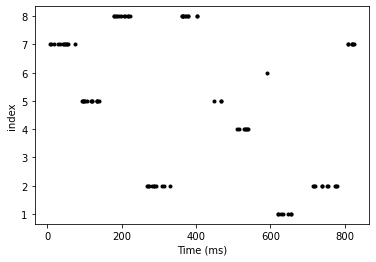

In [93]:
# Plotting output layer
plot(S2.t/ms, S2.i, '.k')
xlabel('Time (ms)')
ylabel('index');

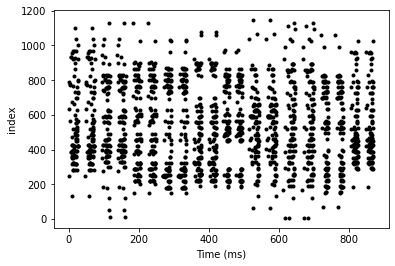

In [94]:
# Plotting the input spike trains
plot(S1.t/ms, S1.i, '.k')
xlabel('Time (ms)')
ylabel('index');

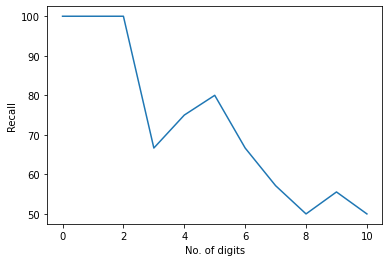

In [95]:
# Plotting the performance graph
tot_dig = 0
corr = 0
recall = [100]
for z in range(len(spike_digits)):
    if(predictions1[z]==spike_digits[z] or predictions2[z]==spike_digits[z] or predictions3[z]==spike_digits[z]):
        corr += 1
    tot_dig += 1
    recall.append((100*corr)/tot_dig)

plot(recall)
xlabel('No. of digits')
ylabel('Recall');  

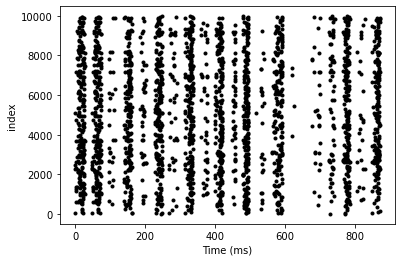

In [98]:
# Plotting the middle layer
plot(S3.t/ms, S3.i, '.k')
xlabel('Time (ms)')
ylabel('index');